# Застосування дерев класифікації у вирішенні завдань інтелектуального аналізу даних

### Підключення бібліотек

> Нижче представлений перелік бібліотек, необхідний для виконання лабораторної роботи, а саме: серія бібіліотек для візуального представлення результатів, а також низка бібліотек різних методів класифікації (дерева класифікації та адгоритм k найближчих сусідів).

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

### 1. Завантаження та обробка даних

> Завнтажимо датасет із освітньою інформацією про студентів. Маємо як чисельні дані (оцінки тестів), так і категоріальні дані (інша релевантна інформація про учнів: стать, раса, рівень освіти батьків тощо).

In [135]:
exams = pd.read_csv("exams.csv")
exams

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68
...,...,...,...,...,...,...,...,...
995,male,group C,high school,standard,none,73,70,65
996,male,group D,associate's degree,free/reduced,completed,85,91,92
997,female,group C,some high school,free/reduced,none,32,35,41
998,female,group C,some college,standard,none,73,74,82


##### 1.1. Чистка даних

> Проведемо чистку даних: бачимо, що датасет не має порожніх (незаповнених) значень NaN.

In [136]:
print(exams.isnull().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


##### 1.2. Огляд розкиду даних

> Побудуємо для числових даних (оцінки за тести з математики, читання та письма) так звані діаграми розкиду або графіки «ящик з вусами». Отримані графіки демонструють квартилі: нижня та верхня сторони ящика завжди перший (25-й процентиль) і третій квартилі (75-й процентиль), а смужка всередині коробки $-$ другий квартиль (медіана). Вусика відображають вихід за межі міжквартильного інтервалу.

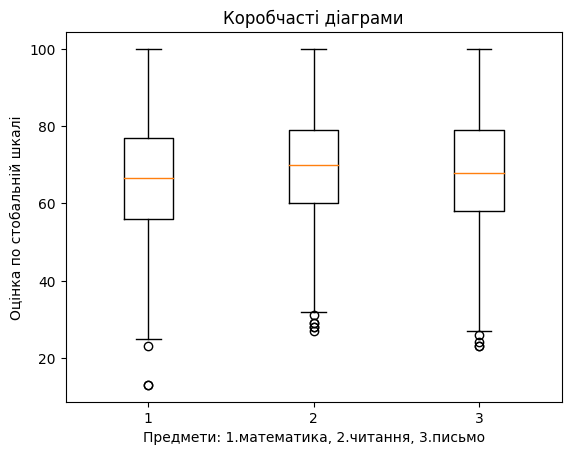

In [137]:
math_score = exams["math score"]
reading_score = exams["reading score"]	
writing_score =  exams["writing score"]

plt.title("Коробчасті діаграми")
plt.xlabel("Предмети: 1.математика, 2.читання, 3.письмо")
plt.ylabel("Оцінка по стобальній шкалі")
plt.boxplot([math_score, reading_score, writing_score])
plt.show()

##### 1.3. Різноманітність категоріальних даних

> Нижче бачимо кількість різних категорій всередині кожного категоріального стовпчика.

In [138]:
print(exams.drop(columns=["math score", "reading score", "writing score"]).nunique())

gender                         2
race/ethnicity                 5
parental level of education    6
lunch                          2
test preparation course        2
dtype: int64


### 2. Підготовка даних для алгоритму дерев класифікації

##### 2.1. Енкодинг категоріальних даних

> Оскільки алгоритми мови Python працюють виключно із числовими даними, пронумеруємо нечислові дані в межах кожної категорії. Порівняльний вигляд датасету наведено нижче.

In [139]:
encoder = LabelEncoder()

for column in exams.columns[1:-3]:
    # fit the encoder to the list of categorical values
    encoder.fit(exams[column])
    # transform the list of categorical values into numerical labels
    exams[column] = encoder.transform(exams[column])

exams

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,0,2,1,0,67,67,63
1,female,3,5,0,1,40,59,55
2,male,4,4,0,1,59,60,50
3,male,1,2,1,1,77,78,68
4,male,4,0,1,0,78,73,68
...,...,...,...,...,...,...,...,...
995,male,2,2,1,1,73,70,65
996,male,3,0,0,0,85,91,92
997,female,2,5,0,1,32,35,41
998,female,2,4,1,1,73,74,82


##### 2.2. Виділення тренувальної та тестової вибріки

> Для прогнозування було обрано стать студентів (змінна y). Відтак, решта ознак будуть виступати матеріалом для проведення прогнозування (змінна x). Наостанок, розділимо дані на 70% тренувальних та 30% тестових даних. 

In [140]:
x = exams.drop(columns=["gender"])
y = exams["gender"]

In [141]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### 3. Побудова класифікатора дерев прийняття рішень

> В ролі класифікатора побудуємо модель дерев прийняття рішень з критерієм розщеплення Джині:
\begin{equation*}
    Gini(D_m) = 1 - \sum\limits_{i=1}^{m} p^2_i,
\end{equation*}
де $p_i$ є імовірністю набору $D_m$ перебувати в одному з $m$ станів.

In [142]:
dt_classifier = DecisionTreeClassifier(criterion="gini") # 'gini', 'entropy', 'log_loss'

# fit the data (learning)
dt_classifier.fit(x_train, y_train)

# make predictions
y_predicted = dt_classifier.predict(x_test)

### 3. Оцінка точності класифікатора дерев прийняття рішень

##### 3.1. Огляд метрик класифікації

> Нижче наведено огляд метрик класифікації при аналізі точності прогнозу статі студентів. Нехай для фіксації звернемо увагу саме на значення акуратності (accuracy). Наступним пунктом наведемо матрицю помилок (confusion_matrix), на основі якої, власне кажучи, і обчислюються метрики класифікації.

In [143]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

      female       0.78      0.77      0.78       146
        male       0.78      0.80      0.79       154

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.78      0.78      0.78       300



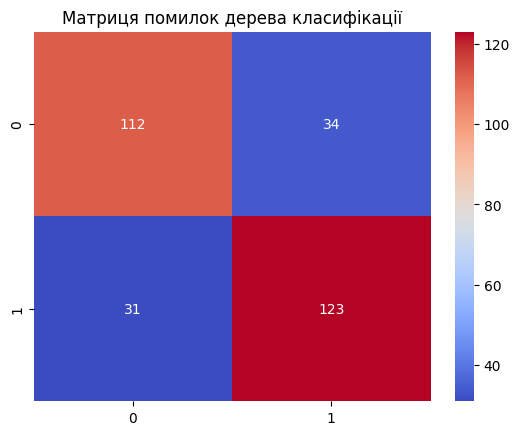

In [144]:
plt.title("Матриця помилок дерева класифікації")
sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, fmt="d", cmap="coolwarm")
plt.show()

> Проведемо візуалізацію дерева. Дерево вийшло доволі громіздким та гіллястим, тому надалі виконаємо обмеження глибини дерева.

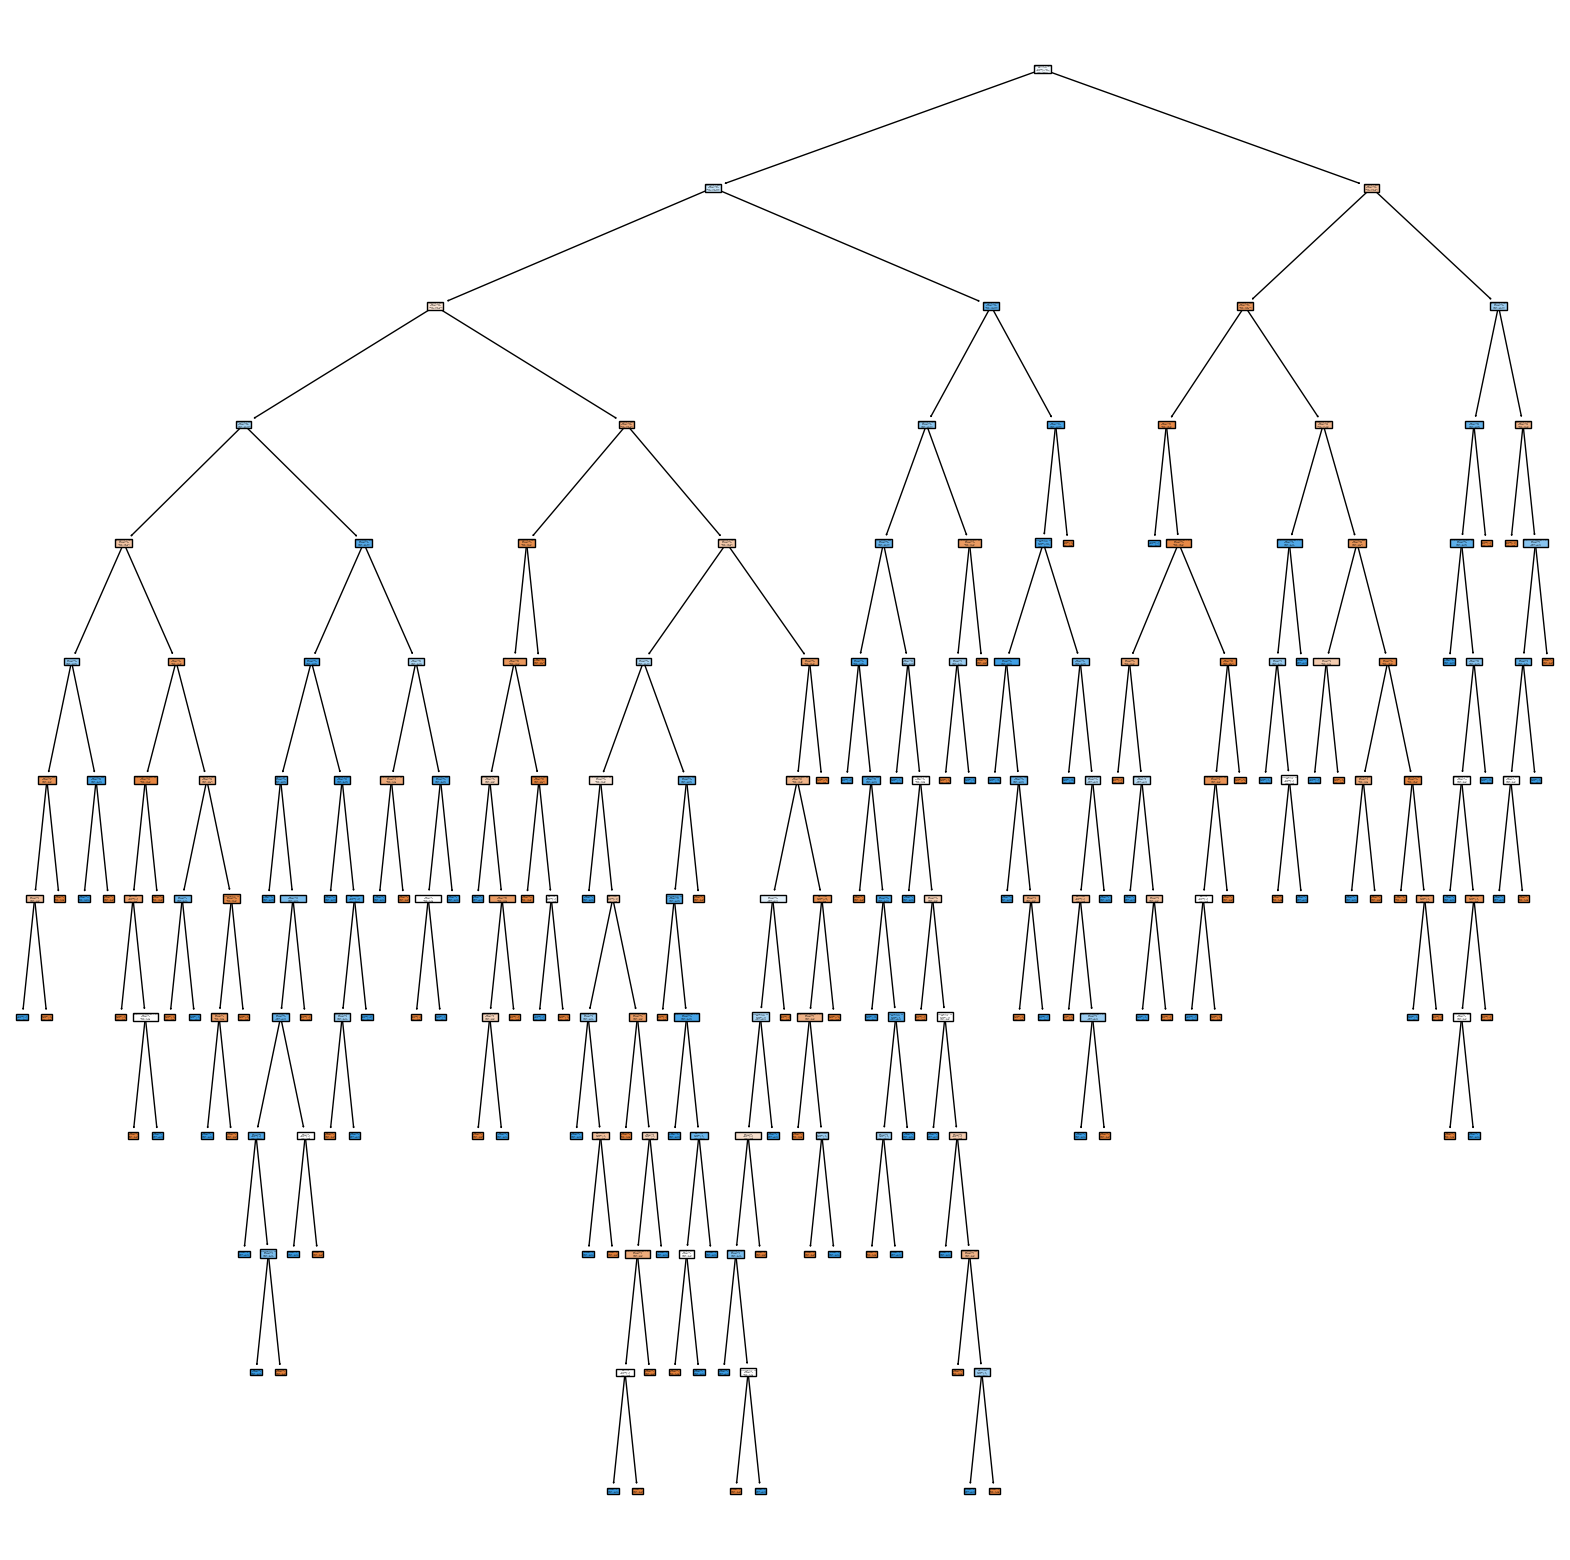

In [145]:
plt.figure(figsize = (20,20))
plot_tree(
    dt_classifier, 
    feature_names = x.columns, 
    class_names = ["male", "female"], 
    filled = True
)
plt.show()

##### 3.2. Процедура обмеження глибини дерева.

> Виконаємо аналогічні кроки при параметрі глибини дерева max_depth=5. Бачимо, що точність класифікації (accuracy) підвищилася. Візуалізація дерева наведена нижче.

              precision    recall  f1-score   support

      female       0.82      0.77      0.80       146
        male       0.80      0.84      0.82       154

    accuracy                           0.81       300
   macro avg       0.81      0.81      0.81       300
weighted avg       0.81      0.81      0.81       300



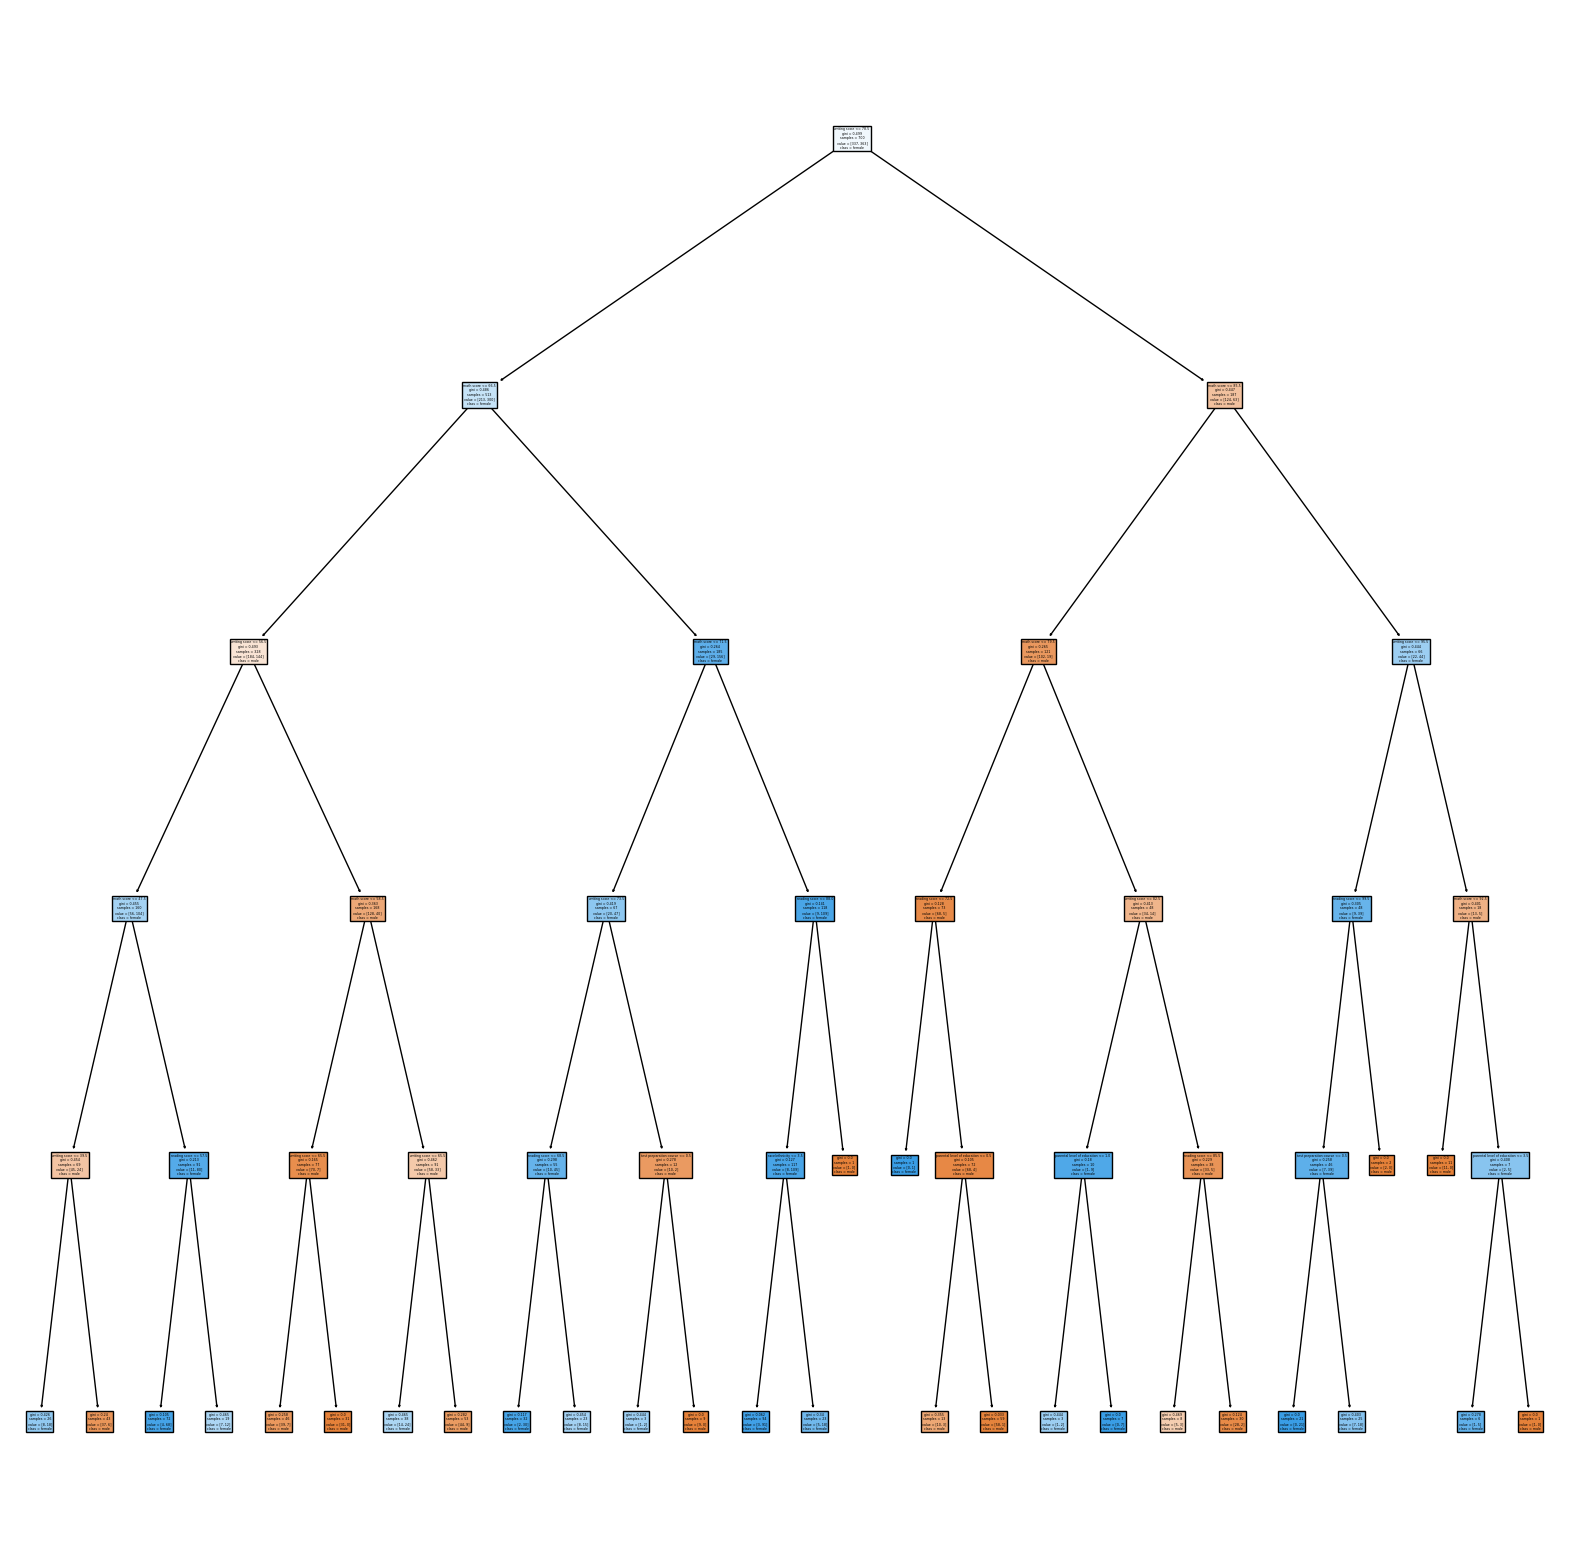

In [146]:
dt_classifier = DecisionTreeClassifier(criterion="gini", max_depth=5)

dt_classifier.fit(x_train, y_train)
y_predicted = dt_classifier.predict(x_test)

print(classification_report(y_test, y_predicted))

plt.figure(figsize = (20,20))
plot_tree(
    dt_classifier, 
    feature_names = x.columns, 
    class_names = ["male", "female"], 
    filled = True
)
plt.show()

### 4. Алгоритм класифікації KNN

##### 4.1. Масштабування даних

> Алгоритм класифікації k найближчих сусідів (далі $-$ KNN) обробляє безпосередні числові значення даних, а відтак є більш чутливим до масштабу чисел. Тому додатковим кроком була проведена нормалізація даних за допомогою нормального розподілу. 

In [147]:
scaler = StandardScaler()
scaler.fit(x_train)

scaled_x_train = scaler.transform(x_train) 
scaled_x_test = scaler.transform(x_test) 

##### 4.2. Побудова класифікатора KNN

> Нехай для KNN покладемо параметр кількості найближчих сусідів як $k=5$.

In [148]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(scaled_x_train, y_train)

y_predicted = knn_classifier.predict(scaled_x_test)

##### 4.3. Оцінка точності класифікатора KNN

> Аналогічним чином наведемо огляд метрик класифікації при аналізі точності прогнозу статі студентів. Звернемо увагу на значення акуратності (accuracy). Наступним пунктом наведемо матрицю помилок (confusion_matrix).

In [149]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

      female       0.77      0.70      0.73       146
        male       0.74      0.80      0.77       154

    accuracy                           0.75       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.75      0.75      0.75       300



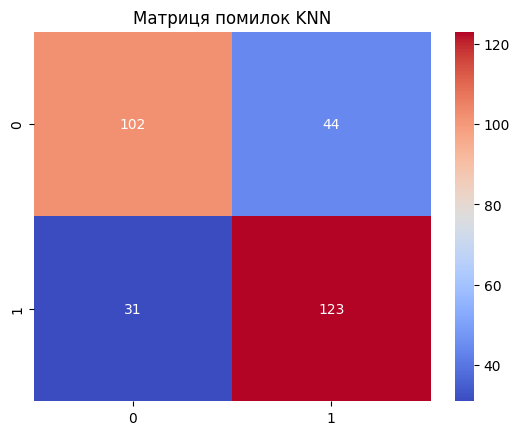

In [150]:
plt.title("Матриця помилок KNN")
sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, fmt="d", cmap="coolwarm")
plt.show()

##### 4.4. Вибір найоптимальнішої кількості сусідів K

> Виконаємо багаторазовий запуск алгоритму KNN при різніх значеннях параметра k (кількості найближчих сусідів). Потім проаналізуємо отриманий графік і оберемо те значення k, якому відповідає найвище значення точності класифікації (accuracy).

In [151]:
accuracy = []

for k in range(1,30):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(scaled_x_train,y_train)
    y_predicted_k = knn_classifier.predict(scaled_x_test)
    accuracy.append(accuracy_score(y_test,y_predicted_k))

k_best = np.argmax(accuracy) + 1
print("Найбільш оптимальне значення параметра k:", k_best)

Найбільш оптимальне значення параметра k: 16


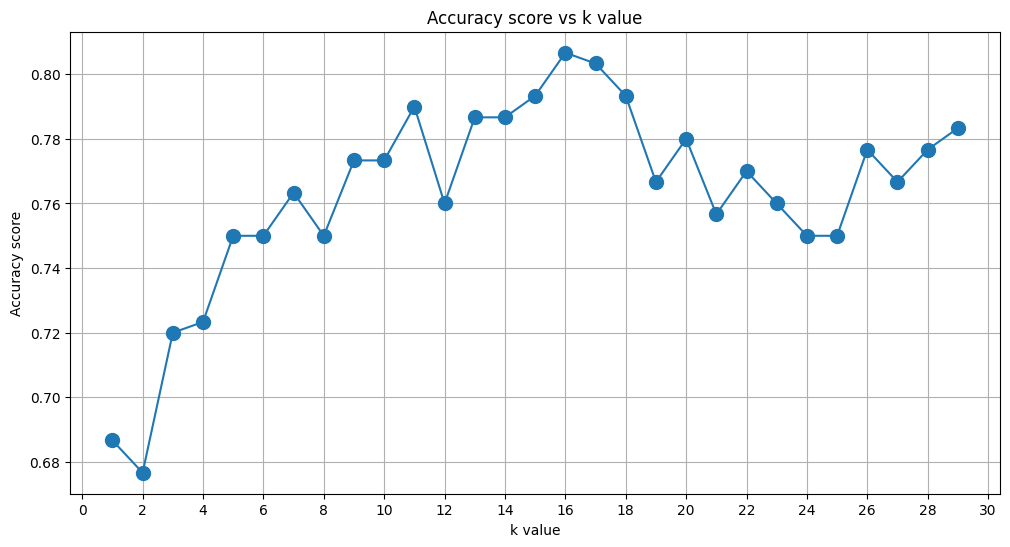

In [152]:
plt.figure(figsize=(12,6))
plt.plot(range(1,30), accuracy, marker='o', markersize=10)
plt.locator_params(axis='x', nbins=30) 
plt.title("Accuracy score vs k value")
plt.xlabel("k value")
plt.ylabel("Accuracy score")
plt.grid()

### 5. Перехресна перевірка

> Наостанок, проведемо більш ґрунтовне порівняння методу дерев класифікації та методу KNN шляхом виконання процедури перехвесної перевірки (cross validation). Іншими словами, процес прогнозування будемо виконувати на наборах тренувальних та тестових даних, підібраних таким чином: розіб'ємо набір даних на 10 блоків і почергово обиратимемо різний блок в якості тестової вибірки.

> В результаті критерієм порівняння обраних методів стане усереднена точність на окреслених наборах тренувальних та тестових вибірок.

In [153]:
dt_classifier = DecisionTreeClassifier(max_depth=5)
knn_classifier = KNeighborsClassifier(n_neighbors=k_best)

dt_scores = cross_val_score(dt_classifier, x, y, cv=10)  # cv = 10 specifies 10-fold cross-validation

# print the accuracy scores for each fold
print("Cross-Validation scores (decision tree):", dt_scores)
# calculate and print the average accuracy
print("Average accuracy (decision tree):", round(dt_scores.mean(),4))

knn_scores = cross_val_score(knn_classifier, x, y, cv=10)  # cv = 10 specifies 10-fold cross-validation

print("\nCross-Validation scores (KNN):", knn_scores)
print("Average accuracy (KNN):", round(knn_scores.mean(),4))

Cross-Validation scores (decision tree): [0.82 0.69 0.79 0.72 0.81 0.76 0.84 0.77 0.79 0.78]
Average accuracy (decision tree): 0.777

Cross-Validation scores (KNN): [0.9  0.87 0.86 0.82 0.77 0.86 0.86 0.78 0.84 0.81]
Average accuracy (KNN): 0.837
